### Data preprocessing and training set generation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import music21 as m21
import json
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import gc
import traceback

In [2]:
# Configuration
SAVE_DIR = "music_dataset"
DATASET_PATH = r"D:\deutschl\essen\europa\deutschl\erk"
SINGLE_FILE_DATASET = "file_dataset"
SEQUENCE_LENGTH = 64
MAPPING_PATH = "mapping.json"
ACCEPTABLE_DURATIONS = [0.25, 0.5, 0.75, 1.0, 1.5, 2, 3, 4]
OUTPUT_UNITS = 38
NUM_UNITS = [256]
LOSS = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 64
SAVE_MODEL_PATH = "model.pth"

In [3]:
print(os.walk(DATASET_PATH))
for paths, subdirs, files in os.walk(DATASET_PATH):
    print(paths)
    print(subdirs)
    print(files)

<generator object _walk at 0x000001E8D25A6880>
D:\deutschl\essen\europa\deutschl\erk
[]
['CKSUM', 'deut0567.krn', 'deut0568.krn', 'deut0569.krn', 'deut0570.krn', 'deut0571.krn', 'deut0572.krn', 'deut0573.krn', 'deut0574.krn', 'deut0575.krn', 'deut0576.krn', 'deut0577.krn', 'deut0578.krn', 'deut0579.krn', 'deut0580.krn', 'deut0581.krn', 'deut0582.krn', 'deut0583.krn', 'deut0584.krn', 'deut0585.krn', 'deut0586.krn', 'deut0587.krn', 'deut0588.krn', 'deut0589.krn', 'deut0590.krn', 'deut0591.krn', 'deut0592.krn', 'deut0593.krn', 'deut0594.krn', 'deut0595.krn', 'deut0596.krn', 'deut0597.krn', 'deut0598.krn', 'deut0599.krn', 'deut0600.krn', 'deut0601.krn', 'deut0602.krn', 'deut0603.krn', 'deut0604.krn', 'deut0605.krn', 'deut0606.krn', 'deut0607.krn', 'deut0608.krn', 'deut0609.krn', 'deut0610.krn', 'deut0611.krn', 'deut0612.krn', 'deut0613.krn', 'deut0614.krn', 'deut0615.krn', 'deut0616.krn', 'deut0617.krn', 'deut0618.krn', 'deut0619.krn', 'deut0620.krn', 'deut0621.krn', 'deut0622.krn', 'deut0

In [4]:
# Utility Functions
def load(file_path):
    with open(file_path, "r") as f:
        return f.read()

def load_songs_in_kern(dataset_path):
    songs = []
    for path, _, files in os.walk(dataset_path):
        for file in files:
            if file[-3:] == "krn":
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)
    return songs

def has_acceptable_durations(song, acceptable_durations):
    for note in song.flatten().notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

def transpose(song):
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4]
    
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")
    
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))
    
    return song.transpose(interval)

def encode_song(song, time_step=0.25):
    encoded_song = []
    for event in song.flatten().notesAndRests:
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi
        elif isinstance(event, m21.note.Rest):
            symbol = "r"
        steps = int(event.duration.quarterLength / time_step)
        for step in range(steps):
            if step == 0:
                encoded_song.append(str(symbol))
            else:
                encoded_song.append("_")
    return " ".join(encoded_song)

def create_single_file_dataset(dataset_path, file_dataset_path, sequence_length):
    new_song_delimiter = "/ " * sequence_length
    songs = ""
    for path, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(path, file)
            song = load(file_path)
            songs = songs + song + " " + new_song_delimiter
    songs = songs[:-1]
    with open(file_dataset_path, "w") as fp:
        fp.write(songs)
    return songs

def create_mapping(songs, mapping_path):
    mappings = {}
    songs = songs.split()
    vocabulary = list(set(songs))
    for i, symbol in enumerate(vocabulary):
        mappings[symbol] = i
    with open(mapping_path, "w") as f:
        json.dump(mappings, f)

def convert_songs_to_int(songs):
    with open(MAPPING_PATH, "r") as f:
        mappings = json.load(f)
    songs = songs.split()
    return [mappings[symbol] for symbol in songs]

def validate_seed(seed, mappings):
    """Validate that all symbols in the seed sequence are in the mappings."""
    seed_symbols = seed.split()
    invalid_symbols = [s for s in seed_symbols if s not in mappings]
    if invalid_symbols:
        print(f"Warning: Invalid symbols in seed: {invalid_symbols}")
        return False
    return True

# Model Definition
def build_model(output_units, num_units):
    class MelodyModel(nn.Module):
        def __init__(self, output_units, num_units):
            super(MelodyModel, self).__init__()
            self.lstm = nn.LSTM(output_units, num_units[0], batch_first=True)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(num_units[0], output_units)
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.dropout(out[:, -1, :])
            out = self.fc(out)
            return out
    return MelodyModel(output_units, num_units)

def load_model(model_path="model.pth", force_cpu=False):
    device = torch.device("cpu") if force_cpu else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Loading model on: {device}")
    model = build_model(output_units=OUTPUT_UNITS, num_units=NUM_UNITS).to(device)
    try:
        state_dict = torch.load(model_path, map_location=device, weights_only=True)
        model.load_state_dict(state_dict)
        print("Model loaded successfully")
    except RuntimeError as e:
        print(f"Error loading model: {e}")
        raise
    model.eval()
    model.device = device
    return model

# Data Preparation
def generate_training_sequences(sequence_length, batch_size=BATCH_SIZE):
    songs = load(SINGLE_FILE_DATASET)
    int_songs = convert_songs_to_int(songs)
    num_sequences = len(int_songs) - sequence_length
    chunk_size = min(batch_size * 5, num_sequences)
    
    for chunk_start in range(0, num_sequences, chunk_size):
        chunk_end = min(chunk_start + chunk_size, num_sequences)
        if torch.cuda.is_available():
            print(f"Memory before chunk processing: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        
        for i in range(chunk_start, chunk_end, batch_size):
            batch_end = min(i + batch_size, chunk_end)
            batch_inputs = [int_songs[j:j + sequence_length] for j in range(i, batch_end)]
            batch_targets = [int_songs[j + sequence_length] for j in range(i, batch_end)]
            vocabulary_size = len(set(int_songs))
            
            encoder = OneHotEncoder(sparse_output=False, categories=[range(vocabulary_size)])
            encoded_sequences = []
            for seq in batch_inputs:
                seq_array = np.array(seq).reshape(-1, 1)
                encoded_seq = encoder.fit_transform(seq_array)
                encoded_sequences.append(encoded_seq)
            
            encoded_inputs = np.array(encoded_sequences)
            if encoded_inputs.size == 0:
                continue
            if encoded_inputs.ndim == 3:
                pass
            else:
                encoded_inputs = encoded_inputs.reshape(len(batch_inputs), sequence_length, vocabulary_size)
            
            yield torch.tensor(encoded_inputs, dtype=torch.float32), torch.tensor(batch_targets, dtype=torch.long)
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print(f"Memory after chunk processing: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

In [5]:
# Training
def train(output_units=OUTPUT_UNITS, num_units=NUM_UNITS, loss_fn=nn.CrossEntropyLoss(), learning_rate=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = build_model(output_units, num_units).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch_inputs, batch_targets in generate_training_sequences(SEQUENCE_LENGTH, BATCH_SIZE):
            batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
            optimizer.zero_grad()
            outputs = model(batch_inputs)
            loss = loss_fn(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / ((len(convert_songs_to_int(load(SINGLE_FILE_DATASET))) - SEQUENCE_LENGTH) // BATCH_SIZE)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {avg_loss:.4f}")
    
    torch.save(model.state_dict(), SAVE_MODEL_PATH)
    return train_losses

# Preprocessing
def preprocess(dataset_path):
    print("Loading songs...")
    songs = load_songs_in_kern(dataset_path)
    print(f"Loaded {len(songs)} songs")
    for i, song in enumerate(songs):
        if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
            continue
        song = transpose(song)
        encoded_song = encode_song(song)
        save_path = os.path.join(SAVE_DIR, str(i))
        with open(save_path, "w") as f:
            f.write(encoded_song)

# Evaluation Functions
def calculate_perplexity(model, sequence_length, batch_size=BATCH_SIZE):
    device = model.device
    model.eval()
    total_log_likelihood = 0
    total_words = 0
    
    for i, (batch_inputs, batch_targets) in enumerate(generate_training_sequences(sequence_length, batch_size)):
        if i % 5 == 0 and device.type == 'cuda':
            print(f"Batch {i} - Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        
        batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
        
        if batch_inputs.size(0) > 4:
            sub_batch_size = 4
            sub_total_log_likelihood = 0
            for j in range(0, batch_inputs.size(0), sub_batch_size):
                end_idx = min(j + sub_batch_size, batch_inputs.size(0))
                sub_inputs = batch_inputs[j:end_idx]
                sub_targets = batch_targets[j:end_idx]
                
                with torch.no_grad():
                    outputs = model(sub_inputs)
                    log_probs = F.log_softmax(outputs, dim=1)
                    sub_total_log_likelihood += torch.sum(log_probs[range(sub_targets.size(0)), sub_targets]).item()
                
                del outputs, log_probs
                if device.type == 'cuda':
                    torch.cuda.empty_cache()
            
            total_log_likelihood += sub_total_log_likelihood
        else:
            with torch.no_grad():
                outputs = model(batch_inputs)
                log_probs = F.log_softmax(outputs, dim=1)
                total_log_likelihood += torch.sum(log_probs[range(batch_targets.size(0)), batch_targets]).item()
            
            del outputs, log_probs
        
        total_words += batch_targets.size(0)
        
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    perplexity = np.exp(-total_log_likelihood / total_words)
    return perplexity

def calculate_bleu_score(generated, reference):
    chencherry = SmoothingFunction()
    bleu_scores = []
    for gen_seq in generated:
        gen_tokens = gen_seq.split()
        ref_tokens = [ref.split() for ref in reference]
        score = sentence_bleu(ref_tokens, gen_tokens, smoothing_function=chencherry.method1)
        bleu_scores.append(score)
    return np.mean(bleu_scores)

def generate_sequences(model, mappings, sequence_length, num_samples=20, temperature=1.0):
    start_symbols = ["/"] * sequence_length
    encoder = OneHotEncoder(sparse_output=False, categories=[range(len(mappings))])
    generated_sequences = []
    device = model.device
    
    batch_size = 2
    for batch_start in range(0, num_samples, batch_size):
        batch_end = min(batch_start + batch_size, num_samples)
        batch_count = batch_end - batch_start
        
        if device.type == 'cuda':
            print(f"Generation batch {batch_start//batch_size + 1} - Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        else:
            print(f"Generation batch {batch_start//batch_size + 1} - Using CPU")
        
        batch_generated = []
        for _ in range(batch_count):
            seed = start_symbols
            melody = seed.copy()
            seed_indices = [mappings.get(s, 0) for s in seed]
            
            for _ in range(50):
                seed_indices = seed_indices[-sequence_length:]
                seed_array = np.array(seed_indices).reshape(-1, 1)
                one_hot_seed = encoder.fit_transform(seed_array)
                one_hot_seed = torch.tensor(one_hot_seed, dtype=torch.float32).unsqueeze(0).to(device)
                
                with torch.inference_mode():
                    outputs = model(one_hot_seed)
                    predictions = outputs.cpu().numpy().flatten()
                    predictions = np.exp(predictions / temperature) / np.sum(np.exp(predictions / temperature))
                    next_index = np.random.choice(len(predictions), p=predictions)
                    next_symbol = list(mappings.keys())[list(mappings.values()).index(next_index)]
                    melody.append(next_symbol)
                    seed_indices.append(next_index)
                
                del one_hot_seed, outputs, predictions
            
            batch_generated.append(" ".join(melody[sequence_length:]))
            gc.collect()
            if device.type == 'cuda':
                torch.cuda.empty_cache()
        
        generated_sequences.extend(batch_generated)
        
        if device.type == 'cuda':
            torch.cuda.empty_cache()
    
    return generated_sequences

def evaluate_model(model_path="model.pth", sequence_length=SEQUENCE_LENGTH, num_samples=10, force_cpu=True):
    print(f"Starting model evaluation (force_cpu={force_cpu})...")
    device = torch.device("cpu") if force_cpu else torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {device} for processing")

    model = load_model(model_path, force_cpu=force_cpu)
    with open(MAPPING_PATH, "r") as f:
        mappings = json.load(f)

    train_losses = train()

    perplexity = calculate_perplexity(model, sequence_length)
    print(f"Perplexity: {perplexity:.4f}")

    generated_sequences = generate_sequences(model, mappings, sequence_length, num_samples)
    reference_sequences = [encode_song(song) for song in load_songs_in_kern(DATASET_PATH)[:num_samples]]
    bleu_score = calculate_bleu_score(generated_sequences, reference_sequences)
    print(f"BLEU Score: {bleu_score:.4f}")

    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    metrics = {'Perplexity': perplexity, 'BLEU Score': bleu_score}
    plt.bar(metrics.keys(), metrics.values())
    plt.title('Model Evaluation Metrics')
    plt.ylabel('Score')
    plt.tight_layout()
    plt.savefig('model_metrics.png')
    print("Metrics visualization saved to 'model_metrics.png'")
    plt.close()

    print("Evaluation complete")
    if device.type == 'cuda':
        print(f"Final memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

def emergency_evaluate(model_path="model.pth"):
    print("\n" + "="*50)
    print("EMERGENCY MINIMAL EVALUATION")
    print("="*50)
    
    try:
        device = torch.device("cpu")
        print("Using CPU for emergency evaluation")
        
        model = build_model(output_units=OUTPUT_UNITS, num_units=NUM_UNITS).to(device)
        state_dict = torch.load(model_path, map_location=device, weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        model.device = device
        print("Model loaded for emergency evaluation")
        
        with open(MAPPING_PATH, "r") as f:
            mappings = json.load(f)
        
        print("Generating 1 test sequence...")
        start_symbols = ["/"] * 32
        seed_indices = [mappings.get(s, 0) for s in start_symbols]
        melody = start_symbols.copy()
        
        encoder = OneHotEncoder(sparse_output=False, categories=[range(len(mappings))])
        
        for _ in range(10):
            seed_indices = seed_indices[-32:]
            seed_array = np.array(seed_indices).reshape(-1, 1)
            one_hot_seed = encoder.fit_transform(seed_array)
            one_hot_seed = torch.tensor(one_hot_seed, dtype=torch.float32).unsqueeze(0)
            
            with torch.no_grad():
                outputs = model(one_hot_seed)
                predictions = outputs.detach().numpy().flatten()
                predictions = np.exp(predictions) / np.sum(np.exp(predictions))
                next_index = np.random.choice(len(predictions), p=predictions)
                next_symbol = list(mappings.keys())[list(mappings.values()).index(next_index)]
                melody.append(next_symbol)
                seed_indices.append(next_index)
            
            del one_hot_seed, outputs, predictions
            gc.collect()
        
        print("Successfully generated a test sequence")
        print("Sample output:", " ".join(melody[-10:]))
        print("Emergency evaluation completed successfully")
        return True
    except Exception as e:
        print(f"Emergency evaluation failed: {e}")
        print(traceback.format_exc())
        return False

In [6]:
# Melody Generator Class
class MelodyGenerator:
    def __init__(self, model_path="model.pth"):
        self.model_path = model_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self._load_model().to(self.device)
        with open(MAPPING_PATH, "r") as f:
            self._mappings = json.load(f)
        self._start_symbols = ["/"] * SEQUENCE_LENGTH
        self.encoder = OneHotEncoder(sparse_output=False, categories=[range(len(self._mappings))])

    def _load_model(self):
        model = build_model(output_units=OUTPUT_UNITS, num_units=NUM_UNITS)
        state_dict = torch.load(self.model_path, map_location=self.device, weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        return model

    def generate_melody(self, seed, num_steps, max_sequence_length, temperature):
        seed = seed.split()
        melody = seed
        seed = self._start_symbols + seed
        seed = [self._mappings[symbol] for symbol in seed]
       
        for _ in range(num_steps):
            seed = seed[-max_sequence_length:]
            seed_array = np.array(seed).reshape(-1, 1)
            one_hot_seed = self.encoder.fit_transform(seed_array)
            one_hot_seed = torch.tensor(one_hot_seed, dtype=torch.float32).unsqueeze(0).to(self.device)

            with torch.inference_mode():
                predictions = self.model(one_hot_seed)
                predictions = predictions.cpu().numpy().flatten()
                predictions = np.exp(predictions / temperature) / np.sum(np.exp(predictions / temperature))
                next_index = np.random.choice(len(predictions), p=predictions)
                next_symbol = list(self._mappings.keys())[list(self._mappings.values()).index(next_index)]
                melody.append(next_symbol)
                seed.append(next_index)

        return " ".join(melody)

    def save_melody(self, melody, step_duration=0.5, format="midi", file_name="mel.mid"):
        stream = m21.stream.Stream()
        start_symbol = None
        step_counter = 1
    
        for i, symbol in enumerate(melody.split()):
            if symbol != "_" and symbol.strip():
                if start_symbol is not None:
                    quarter_length_duration = step_duration * step_counter
                    if start_symbol == "r":
                        m21_event = m21.note.Rest(quarterLength=quarter_length_duration)
                    elif start_symbol.isdigit():
                        m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)
                    else:
                        continue
                    stream.append(m21_event)
                    step_counter = 1
                start_symbol = symbol
            else:
                step_counter += 1
    
        if start_symbol and start_symbol.strip():
            quarter_length_duration = step_duration * step_counter
            if start_symbol == "r":
                m21_event = m21.note.Rest(quarterLength=quarter_length_duration)
            elif start_symbol.isdigit():
                m21_event = m21.note.Note(int(start_symbol), quarterLength=quarter_length_duration)
            else:
                m21_event = None
            if m21_event:
                stream.append(m21_event)

        stream.write(format, file_name)

In [ ]:
# Main Execution
if __name__ == "__main__":
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    print("Starting preprocessing...")
    preprocess(DATASET_PATH)
    songs = create_single_file_dataset(SAVE_DIR, SINGLE_FILE_DATASET, SEQUENCE_LENGTH)
    create_mapping(songs, MAPPING_PATH)
    
    print("Starting training...")
    train()
    
    print("Generating melody...")
    try:
        if not os.path.exists(SAVE_MODEL_PATH) or not os.path.exists(MAPPING_PATH):
            raise FileNotFoundError("Required files (model.pth or mapping.json) are missing.")
        
        with open(MAPPING_PATH, "r") as f:
            mappings = json.load(f)
        
        seed = "55 _ _ _ 60 _ _ _ 55 _ _ _ 55 _"
        if not validate_seed(seed, mappings):
            print("Using fallback seed sequence...")
            seed = "/ _ _ _ r _ _ _ / _ _ _ r _"
        
        mg = MelodyGenerator()
        # Reduced num_steps to 100 for memory efficiency; increase to 1000 for longer melodies
        melody = mg.generate_melody(seed, 100, SEQUENCE_LENGTH, 1.5)
        print("Generated melody:", melody)
        mg.save_melody(melody, file_name="generated_melody.mid")
    except Exception as e:
        print(f"Melody generation failed: {e}")
        print(traceback.format_exc())
    
    print("Starting evaluation on CPU...")
    try:
        evaluate_model(force_cpu=True, num_samples=10)
    except Exception as e:
        print(f"CPU evaluation failed: {e}")
        print(traceback.format_exc())
        print("\nAttempting emergency evaluation mode...")
        emergency_evaluate()

Starting preprocessing...
Loading songs...
Loaded 1700 songs
Starting training...
Memory before chunk processing: 0.00 GB


C:\Users\ARNAV\AppData\Local\Temp\ipykernel_23332\1444027543.py:17: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Scalar.cpp:23.)
  total_loss += loss.item()


Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before chunk processing: 0.02 GB
Memory after chunk processing: 0.02 GB
Memory before

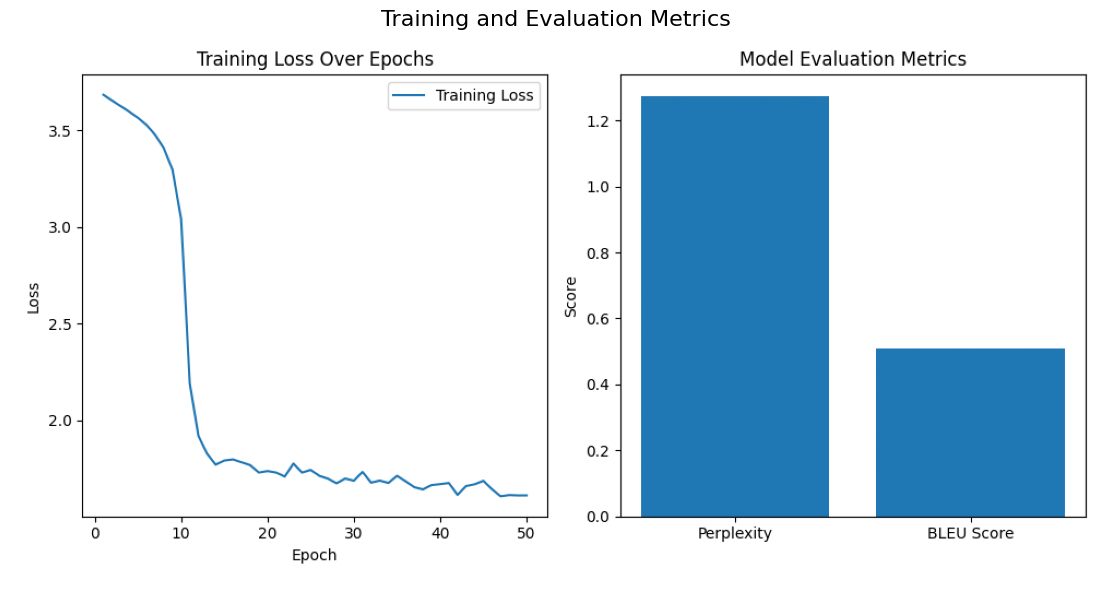

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
image_path = "model_metrics.png"  # Update path if needed
img = mpimg.imread(image_path)

# Plot the image with a larger figure size
fig = plt.figure(figsize=(12, 6))  # Width x Height in inches
plt.imshow(img)
plt.axis('off')  # Turn off axis for a clean look
plt.title("Training and Evaluation Metrics", fontsize=16)
plt.tight_layout()
plt.show()
fig.savefig("scaled_output.png", dpi=300, bbox_inches='tight')
